In [19]:
import os
import matplotlib
import numpy as np
import typing as t
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from v1t.utils import utils, yaml, tensorboard

utils.set_random_seed(1234)

tensorboard.set_font()

TRAIN_SIZES = [500, 1500, 2500, 3500, 4500]

In [20]:
def p_value_to_asterisks(p_value: float):
    text = "n.s."
    if p_value <= 0.0001:
        text = "****"
    elif p_value <= 0.001:
        text = "***"
    elif p_value <= 0.01:
        text = "**"
    elif p_value <= 0.05:
        text = "*"
    return text


def get_results(dir: str):
    results = {}
    for train_size in TRAIN_SIZES:
        if train_size not in results:
            results[train_size] = {}
        for model in ["stacked2d", "vit", "v1t"]:
            if model not in results[train_size]:
                results[train_size][model] = []
            output_dirs = glob(os.path.join(dir, str(train_size), model, "*"))
            for output_dir in output_dirs:
                filename = os.path.join(output_dir, "evaluation.yaml")
                if os.path.exists(filename):
                    result = yaml.load(filename)
                    results[train_size][model].append(
                        result["single_trial_correlation"]["average"]
                    )
    return results


def get_summary(results: t.Dict[int, t.Dict[str, t.List[float]]]):
    cnn_results = {"mean": [], "std": []}
    vit_results = {"mean": [], "std": []}
    v1t_results = {"mean": [], "std": []}
    p_values = {"cnn": [], "vit": []}
    for train_size, result in results.items():
        cnn, vit, v1t = result["stacked2d"], result["vit"], result["v1t"]

        if len(cnn) < 30:
            print(f"CNN (train size: {train_size}) contains only {len(cnn)}/30 runs.")
        if len(vit) < 30:
            print(f"ViT (train size: {train_size}) contains only {len(vit)}/30 runs.")
        if len(v1t) < 30:
            print(f"V1T (train size: {train_size}) contains only {len(v1t)}/30 runs.")

        cnn_results["mean"].append(np.mean(cnn))
        cnn_results["std"].append(np.std(cnn))

        vit_results["mean"].append(np.mean(vit))
        vit_results["std"].append(np.std(vit))

        v1t_results["mean"].append(np.mean(v1t))
        v1t_results["std"].append(np.std(v1t))

        # p-value between CNN and V1T
        cnn_t_test = ttest_ind(cnn, v1t)
        p_values["cnn"].append(p_value_to_asterisks(cnn_t_test.pvalue))

        # p-value between ViT and V1T
        vit_t_test = ttest_ind(vit, v1t)
        p_values["vit"].append(p_value_to_asterisks(vit_t_test.pvalue))

    return cnn_results, vit_results, v1t_results, p_values


results = get_results("../runs/limit_data")
cnn_results, vit_results, v1t_results, p_values = get_summary(results)

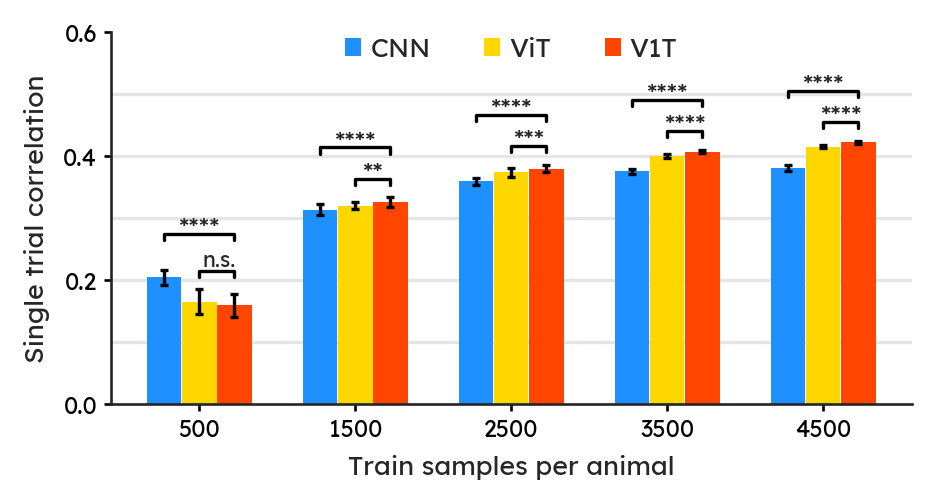

In [21]:
tick_fontsize, label_fontsize, title_fontsize = 7, 8, 9
width, y_max, bar_pad, edgewidth = 0.22, 0.6, 0.005, 0.0
error_kw = {"elinewidth": 1, "capsize": 1.2}
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(4, 2.2), dpi=240)

x_axis = np.arange(1, len(TRAIN_SIZES) + 1)
x_labels = TRAIN_SIZES

# plot CNN results
axis.bar(
    x_axis - width - bar_pad,
    height=cnn_results["mean"],
    yerr=cnn_results["std"],
    width=width,
    align="center",
    label="CNN",
    color="dodgerblue",
    edgecolor="dodgerblue",
    linewidth=edgewidth,
    error_kw=error_kw,
)

# plot ViT results
axis.bar(
    x_axis,
    height=vit_results["mean"],
    yerr=vit_results["std"],
    width=width,
    align="center",
    label="ViT",
    color="gold",
    edgecolor="gold",
    linewidth=edgewidth,
    error_kw=error_kw,
)

# plot V1T results
axis.bar(
    x_axis + width + bar_pad,
    height=v1t_results["mean"],
    yerr=v1t_results["std"],
    width=width,
    align="center",
    label="V1T",
    color="orangered",
    edgecolor="orangered",
    linewidth=edgewidth,
    error_kw=error_kw,
)

axis.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncols=3,
    frameon=False,
    handletextpad=0.35,
    handlelength=0.6,
    markerscale=0.8,
    columnspacing=2,
    fontsize=label_fontsize,
)

tensorboard.set_xticks(
    axis,
    ticks_loc=x_axis,
    ticks=x_labels,
    label="Train samples per animal",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)
axis.set_ylim(0, y_max)
y_ticks = np.linspace(0, y_max, 4)
tensorboard.set_yticks(
    axis,
    ticks_loc=y_ticks,
    ticks=y_ticks.round(1),
    label="Single trial correlation",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)

# plot y-axis grid lines
for y_value in np.linspace(0, y_max, 7):
    if 0 < y_value < y_max:
        axis.axhline(y_value, color="gray", alpha=0.2, linewidth=1, zorder=0)

# plot ViT - V1T p-value asterisks
text_heights = []
for i in range(len(TRAIN_SIZES)):
    x_start = x_axis[i]
    lx = x_start
    rx = x_start + width + bar_pad
    y = (
        max(
            vit_results["mean"][i] + vit_results["std"][i],
            v1t_results["mean"][i] + v1t_results["std"][i],
        )
        + 0.02
    )
    barx = [lx, lx, rx, rx]
    y_offset = 0.01
    bary = [y, y + y_offset, y + y_offset, y]
    axis.plot(barx, bary, color="black", linewidth=1)
    p_value = p_values["vit"][i]
    ns = p_value == "n.s."
    text_height = y + 0.01 if ns else y
    axis.text(
        x=(lx + rx) / 2 + 0.015 if ns else (lx + rx) / 2,
        y=text_height,
        s=p_value,
        ha="center",
        va="bottom",
        fontsize=label_fontsize - 1.5 if ns else label_fontsize,
    )
    text_heights.append(text_height)

# plot CNN - V1T p-value asterisks
for i in range(len(TRAIN_SIZES)):
    x_start = x_axis[i]
    lx = x_start - width - bar_pad
    rx = x_start + width + bar_pad
    y = text_heights[i] + 0.05
    barx = [lx, lx, rx, rx]
    y_offset = 0.01
    bary = [y, y + y_offset, y + y_offset, y]
    axis.plot(barx, bary, color="black", linewidth=1)
    p_value = p_values["cnn"][i]
    ns = p_value == "n.s."
    axis.text(
        x=(lx + rx) / 2,
        y=y + 0.01 if ns else y,
        s=p_value,
        ha="center",
        va="bottom",
        fontsize=label_fontsize - 1.5 if ns else label_fontsize,
    )


sns.despine(ax=axis, top=True, right=True, trim=False)
tensorboard.set_ticks_params(axis=axis, length=2)

figure.tight_layout()

tensorboard.save_figure(figure, filename=f"plots/limit_data.pdf", dpi=240, close=False)

plt.show()
plt.close(figure)
